# <b>Bayesify</b>
## analizing liked songs features using bayesian networks
Spotyfy's API provides lots of data about songs. I've made a tataset with my latest 500 liked songs, and 300 other songs that i dislike.<br>
In this notebook, this dataset will be analyzed using Bayesian Networks trying out different methods of inference, and trying to build a good model with causal relationship between the features of the dataset.<br>


## <b>1. Dataset analysis</b>
First, the dataset is imported.

In [72]:
import pgmpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import dataset
data=pd.read_csv("spotifyData.csv")
#drop first column
data=data.drop(data.columns[0],axis=1)
genre_dict = { 1: 'country', 2: 'trap',3:'edm', 4:'pop', 5: 'indie', 6: 'metal', 7: 'rock', 8: 'hip-hop', 9: 'soul', 10: 'r&b',  11: 'jazz'}
# print sum of each genre, and drop colums with less than 10 rows
'''
for i in range(1,12):
    if sum(data['genre']==i)<10:
        data=data.drop(data[data['genre']==i].index)
    print (genre_dict[i], sum(data['genre']==i)) '''
    

"\nfor i in range(1,12):\n    if sum(data['genre']==i)<10:\n        data=data.drop(data[data['genre']==i].index)\n    print (genre_dict[i], sum(data['genre']==i)) "

The values are discretized, as pgmpy does not fully support continuous values. <br>
Most of the features are continuous and between 0 and 1, so they have been multiplied by 100 and rounded down to the nearest integer, so the're now integer values ranging from 0 to 100.<br>
It's important to notice that Bayesian networks are not very much influenced by outliers, for that reason the data hasn't been scaled.

In [73]:
#integer casting of tempo and loudness
data['tempo']=data['tempo'].apply(lambda x: int(x))
data['loudness']=data['loudness'].apply(lambda x: int(x))
#discretize all percentages (danceability, energy, acousticness and valence, instrumentalness)
#multiply them by 100 and floor
data['danceability']=data['danceability'].apply(lambda x: int(x*100))
data['energy']=data['energy'].apply(lambda x: int(x*100))
data['acousticness']=data['acousticness'].apply(lambda x: int(x*100))
data['valence']=data['valence'].apply(lambda x: int(x*100))
#instrumentalness is 0 if it is 0, 1 otherwise
data['instrumentalness']=data['instrumentalness'].apply(lambda x: 0 if x<=0.1 else 1)

data.head()

,danceability,energy,loudness,acousticness,instrumentalness,valence,tempo,genre,like
0,75,81,-5,7,0,95,98,4,1
1,54,79,-5,33,1,51,104,11,1
2,21,56,-14,80,0,25,76,11,1
3,50,93,-6,53,1,89,117,11,1
4,66,51,-14,32,1,60,99,9,1


The following is a brief description of the meaning of the features in the dataset, taken by the official Spotify's API documentation page:
<i>
- <b>danceability</b><br>
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- <b>energy</b><br>
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- <b>loudness</b><br>
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- <b>acousticness</b><br>
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- <b>instrumentalness</b>:<br>
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- <b>valence</b><br>
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- <b>tempo</b><br>
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
</i>

<br>
<b>Like </b> and <b>Genre</b> have been added by me, the first is binary and 1 means I like the song, 0 otherwise.<br>
Genre is the main Genre of the artist mapped into the following dictionary:<br>

>{ 1: 'country', 2: 'trap',3:'edm', 4:'pop', 5: 'indie', 6: 'metal', 7: 'rock', 8: 'hip-hop', 9: 'soul', 10: 'r&b',  11: 'jazz'}

<br>The heat map correlation graph is shown below to understand possible correlations betwen features using data


<AxesSubplot: >

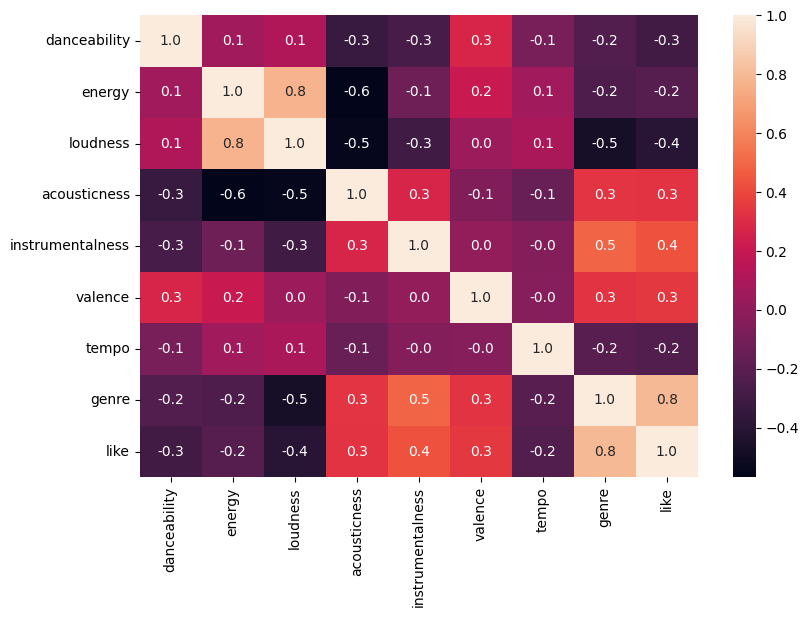

In [74]:
fig= plt.figure(figsize=(9,6))
sns.heatmap(data.corr(),annot=True, fmt=".1f")

## <b>2. Model Creation </b>
From the domain knowledge (given by the features description), the correlation analysis, and via trial and error, the final model obtained has this topology.

(image of the final network, graph)

In [75]:
#create model in pgmpy
from pgmpy.models import BayesianNetwork
#create a dummy dataset with only 10data_dummy samples with like=1 and 10 samples with like=0
data1=data[data['like']==1].sample(n=20)
data2=data[data['like']==0].sample(n=20)
data_dummy=pd.concat([data1,data2])

In [76]:

custom_model1 = BayesianNetwork([('loudness', 'energy'), ('tempo', 'energy'),
                                ('energy', 'valence'), ('danceability', 'valence'),
                              ('valence', 'like'), ('acousticness', 'like'),('instrumentalness', 'like'), ('genre', 'like')])
custom_model = BayesianNetwork([('genre', 'like'), ("valence", "like"), ("instrumentalness", "genre"), ("instrumentalness", "like")])


Learn parameters

In [77]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
custom_model.fit(data, estimator=BayesianEstimator)
print(custom_model.check_model())
#USEFUL INFORMATIONS ABOUT THE NETWORK
#custom_model.get_independencies()
custom_model.get_markov_blanket("like")


True


['instrumentalness', 'genre', 'valence']

## <b>4. Inference</b>
Different queries are performed to infer the probability of certain features.

In [83]:
# make inference
from pgmpy.inference import VariableElimination
from pgmpy.inference import ApproxInference
from pgmpy.inference import BeliefPropagation
from pgmpy.inference import CausalInference
infer=VariableElimination(custom_model)
# query for the probability that ApproxInference(custom_model)i like a song given that the tempo is less than 100

q = infer.query(variables=['like'], evidence={"instrumentalness":0, "genre":11}, show_progress=True)
# barplot with seaborn
# sns.barplot(x=[0,1], y=q['like'].values)
print(q)


+---------+-------------+
| like    |   phi(like) |
+=========+=============+
| like(0) |      0.4055 |
+---------+-------------+
| like(1) |      0.5945 |
+---------+-------------+
